Install libraries we will be using

In [ ]:
!pip install torch==2.0.1 torchvision==0.15.2 transformers==4.31.0


  Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached transformers-4.31.0-py3-none-any.whl.metadata (116 kB)
  Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.0 kB)
Using cached torch-2.0.1-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
Using cached torchvision-0.15.2-cp311-cp311-manylinux1_x86_64.whl (6.0 MB)
Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0


Upload documents and make structure data

In [ ]:
import pandas as pd
import re

def process_transcription(file_name):
    """
    Process a transcription file to extract structured data.
    """
    try:
        with open(file_name, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        raise FileNotFoundError("The specified file was not found.")

    # Extract metadata from the file name
    match = re.match(r"Plaza (.+) Edades (.+) NSE (.+)\.txt", file_name.split('/')[-1])
    if not match:
        raise ValueError("File name format is incorrect. Expected format: 'Plaza [Name] Edades [Range] NSE [Value].txt'")

    plaza, ages, nse = match.groups()

    data = []
    # Adjusted pattern to handle both mm:ss and hh:mm:ss
    pattern = r"^(\d{1,2}:\d{2}(?::\d{2})?)\s+([^:]+):\s+(.+)"

    for line in lines:
        match = re.match(pattern, line)
        if match:
            time, name, participation = match.groups()

            # Normalize mm:ss to hh:mm:ss
            if len(time.split(':')) == 2:
                time = f"00:{time}"

            data.append({
                'Time': time,
                'Name': name,
                'Participation': participation.strip(),
                'Plaza': plaza,
                'NSE': nse,
                'Ages': ages
            })

    if not data:
        raise ValueError("No valid data extracted from the transcription file.")

    df = pd.DataFrame(data)
    return df

# List of file names
file_names = [
    "/content/Assignment 2/data/raw/Plaza CDMX Edades 20 - 30 años NSE C-.txt",
    "/content/Assignment 2/data/raw/Plaza CDMX Edades 35 - 55 años NSE C+.txt",
    "/content/Assignment 2/data/raw/Plaza GDL Edades 20 - 30 años NSE C-.txt",
    "/content/Assignment 2/data/raw/Plaza GDL Edades 35 - 55 años NSE C+.txt",
    "/content/Assignment 2/data/raw/Plaza MTY Edades 20 - 30 años NSE C+.txt",
    "/content/Assignment 2/data/raw/Plaza MTY Edades 35 - 55 años NSE C-.txt"
]

all_dataframes = []

try:
    for file_name in file_names:
        # Process each transcription file
        df = process_transcription(file_name)
        all_dataframes.append(df)

    # Combine all dataframes into one
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    # Display the first rows of the combined DataFrame
    print(combined_df.head())

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv("combined_transcriptions.csv", index=False, encoding='utf-8')
    print("All files processed and saved successfully.")

except Exception as e:
    print(f"An error occurred: {e}")


       Time                               Name  \
0  00:02:04                     Karime Galicia   
1  00:02:13                     Nallive Flores   
2  00:02:13                     Karime Galicia   
3  00:02:14  Yernne Caban Guadalupe Vega Acuña   
4  00:02:22                     Karime Galicia   

                                       Participation Plaza NSE          Ages  
0  Hola Miguel Hola nayibe Hola jerne, cómo están...  CDMX  C-  20 - 30 años  
1                                 Hola buenas tardes  CDMX  C-  20 - 30 años  
2                     Hola Bueno buenas tardes, cómo  CDMX  C-  20 - 30 años  
3                                Hola Bien, gracias.  CDMX  C-  20 - 30 años  
4  Qué bueno, Qué gusto tenerlos por aquí mi nomb...  CDMX  C-  20 - 30 años  
All files processed and saved successfully.


Assign groups

In [ ]:
# Load the cleaned DataFrame
cleaned_df = pd.read_csv("/content/Assignment 2/data/combined_transcriptions.csv")

# Assign group numbers based on Plaza, NSE, and Ages
unique_groups = cleaned_df.groupby(['Plaza', 'NSE', 'Ages']).ngroup()
cleaned_df['Group'] = unique_groups

# Save the updated DataFrame
cleaned_df.to_csv("transcriptions_with_groups.csv", index=False, encoding='utf-8')

print("Group column added based on Plaza, NSE, and Ages and saved to 'transcriptions_with_groups.csv'.")

Group column added based on Plaza, NSE, and Ages and saved to 'transcriptions_with_groups.csv'.


Hash participants and add moderators


In [ ]:
import hashlib

# List of known moderators
moderators = ["Karime Galicia", "Mario Juárez", "Natalia Rodríguez", "Diego De Alba Montes"]

def anonymize_and_flag(df):
    """
    Add a column to flag if the person is a Moderator or Participant,
    and anonymize the names of participants.
    """
    # Create a column to flag if the row corresponds to a Moderator
    df['Role'] = df['Name'].apply(lambda x: 'Moderator' if x in moderators else 'Participant')

    # Anonymize names for participants
    def anonymize_name(name, role):
        if role == 'Participant':
            return hashlib.sha256(name.encode()).hexdigest()[:10]  # Return first 10 characters of hash
        return name  # Keep moderator names unchanged

    df['Anonymized_Name'] = df.apply(lambda row: anonymize_name(row['Name'], row['Role']), axis=1)

    return df

# Load the previously saved DataFrame
combined_df = pd.read_csv("/content/Assignment 2/data/transcriptions_with_groups.csv")

# Process the DataFrame to flag roles and anonymize participant names
processed_df = anonymize_and_flag(combined_df)

# Save the processed DataFrame to a new CSV file
processed_df.to_csv("transcriptions_with_moderators_and_groups.csv", index=False, encoding='utf-8')

print("Names anonymized and roles flagged successfully.")

Names anonymized and roles flagged successfully.


Clean the text for basic analysis

In [ ]:
!pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
# Download the 'punkt_tab' resource for Spanish sentence tokenization
nltk.download('punkt_tab') # This line was added

def clean_text(participation):
    """
    Clean and preprocess the participation text.
    """
    # Remove non-alphanumeric characters, except spaces
    text = re.sub(r'[^\w\s]', '', participation)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text, language='spanish')
    # Remove stopwords (in Spanish)
    spanish_stopwords = set(stopwords.words('spanish'))
    cleaned_tokens = [token for token in tokens if token not in spanish_stopwords]
    # Join tokens back into a string
    return ' '.join(cleaned_tokens)

def preprocess_data(df):
    """
    Apply text cleaning to the participation column while keeping the time.
    """
    df['Cleaned_Participation'] = df['Participation'].apply(clean_text)
    return df

# Load the previously processed DataFrame
processed_df = pd.read_csv("/content/Assignment 2/data/transcriptions_with_moderators_and_groups.csv")

# Clean the participation column
cleaned_df = preprocess_data(processed_df)

# Save the cleaned DataFrame to a new CSV file
cleaned_df.to_csv("cleaned_transcriptions.csv", index=False, encoding='utf-8')

print("Participation text cleaned and saved successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Participation text cleaned and saved successfully.


Clean the text for analysis with BETO

In [ ]:
# Function to clean text without removing stopwords
def clean_text_preserve_stopwords(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # Remove irrelevant special characters (except basic punctuation)
        text = re.sub(r"[^\w\s,.¿?!¡]", '', text)
        # Convert text to lowercase
        text = text.lower()
        return text.strip()  # Remove extra spaces
    return text

# Load the file with the original participation data
file_path = "/content/Assignment 2/data/cleaned_transcriptions.csv"
df = pd.read_csv(file_path)

# Apply text cleaning while preserving stopwords
df['Cleaned_for_Beto'] = df['Participation'].apply(clean_text_preserve_stopwords)

# Save the updated file
output_path = "/content/Assignment 2/data/transcriptions_with_cleaned_Beto.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"File with basic text cleaning that preserves stopwords saved at '{output_path}'.")


File with basic text cleaning that preserves stopwords saved at '/content/Assignment 2/data/transcriptions_with_cleaned_Beto.csv'.


Themes aplication to participation

In [ ]:
import pandas as pd
import re

# Final adjusted thematic categories in English (excluding proper nouns)
thematic_categories = {
    "General opinions about the country": ["país", "méxico", "nación", "gobierno"],
    "Economic problems": ["desigualdad", "economía", "crisis", "jodidos"],
    "Security problems": ["crimen", "violencia", "inseguridad", "narco", "robo", "asalto"],
    "Corruption problems": ["corrupción", "impunidad", "transa", "mordida"],
    "Post-electoral mood": ["elección", "fraude", "optimismo", "desilusión", "votación", "legitimidad", "sentimiento", "emoción", "elecciones"],
    "Morena": ["obrador", "amlo", "morena", "moreno", "guinda", "andres manuel lopez"],
    "Movimiento Ciudadano": ["movimiento ciudadano", "naranja", "canción"],
    "PRIAN": ["pri", "anaya", "pan", "prian", "xochitl"],
    "Sheinbaum": ["claudia", "sheinbaum", "presidenta"],
    "Samuel García": ["samuel", "garcia", "nuevo leon", "gobernador"],
    "Maynez": ["maynez", "maines", "dirigencia", "liderazgo", "presidencia del partido", "sí saben quién"]
}

# Function to classify participation into multiple themes
def classify_multiple_thematic_categories(text, categories):
    assigned_themes = set()
    if isinstance(text, str):
        text = text.lower()  # Normalize text to lowercase
        for theme, keywords in categories.items():
            for keyword in keywords:
                if re.search(rf'\b{keyword}\b', text):
                    assigned_themes.add(theme)
    return ", ".join(assigned_themes) if assigned_themes else "Unclassified"

# Apply thematic classification
def classify_thematic_categories(group):
    group['Thematic_Categories'] = group['Cleaned_for_Beto'].apply(
        lambda text: classify_multiple_thematic_categories(text, thematic_categories)
    )
    return group

# Updated contextualization rule for "Maynez"
def classify_maynez_with_context(group):
    for index, row in group.iterrows():
        # Check if the participation contains terms specific to Maynez
        if isinstance(row['Cleaned_for_Beto'], str):
            text = row['Cleaned_for_Beto'].lower()

            # High-priority keywords for Maynez
            keywords = ["maynez", "maines", "movimiento ciudadano"]
            leadership_terms = ["dirigente", "presidente", "liderazgo", "presidencia del partido"]

            # Check if any high-priority keyword exists
            if any(keyword in text for keyword in keywords):
                current_themes = set(row['Thematic_Categories'].split(", ")) if isinstance(row['Thematic_Categories'], str) else set()
                current_themes.add("Maynez")
                group.at[index, 'Thematic_Categories'] = ", ".join(current_themes)

            # Check for leadership context
            if "movimiento ciudadano" in text and any(term in text for term in leadership_terms):
                current_themes = set(row['Thematic_Categories'].split(", ")) if isinstance(row['Thematic_Categories'], str) else set()
                current_themes.add("Maynez")
                group.at[index, 'Thematic_Categories'] = ", ".join(current_themes)
    return group

# Propagate moderator themes to participant responses within the same group and plaza
def propagate_moderator_themes(group):
    current_theme = None
    for index, row in group.iterrows():
        if row['Role'] == 'Moderator' and row['Thematic_Categories'] != "Unclassified":
            current_theme = row['Thematic_Categories']
        elif row['Role'] == 'Participant' and current_theme:
            if row['Thematic_Categories'] == "Unclassified":
                group.at[index, 'Thematic_Categories'] = current_theme
            else:
                existing_themes = set(row['Thematic_Categories'].split(", "))
                new_themes = existing_themes.union(set(current_theme.split(", ")))
                group.at[index, 'Thematic_Categories'] = ", ".join(new_themes)
    return group

# Load the cleaned transcriptions file
data_path = "/content/Assignment 2/data/transcriptions_with_cleaned_Beto.csv"
cleaned_df = pd.read_csv(data_path, encoding='utf-8')

# Sort data chronologically within groups
cleaned_df = cleaned_df.sort_values(by=['Group', 'Plaza', 'Time'])

# Apply thematic classification
cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(classify_thematic_categories)

# Apply the updated "Maynez" rule
cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(classify_maynez_with_context)

# Propagate themes exclusively for moderators
cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(propagate_moderator_themes)

# Save the results to a new CSV file
output_path = "multi_thematic_classified_transcriptions_reviewed_with_updated_maynez.csv"
cleaned_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Multi-thematic classification with updated rules completed, saved to '{output_path}'.")



<ipython-input-15-6909388f58ff>:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(classify_thematic_categories)
<ipython-input-15-6909388f58ff>:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(classify_maynez_with_context)


Multi-thematic classification with updated rules completed, saved to 'multi_thematic_classified_transcriptions_reviewed_with_updated_maynez.csv'.


<ipython-input-15-6909388f58ff>:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cleaned_df = cleaned_df.groupby(['Group', 'Plaza'], group_keys=False).apply(propagate_moderator_themes)


Sentiment analisis with Beto and transformers

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm  # For showing progress

# Enable tqdm to work properly in Jupyter/Colab environments
tqdm.pandas()

# Load the file with processed text
file_path = "/content/Assignment 2/data/multi_thematic_classified_transcriptions_reviewed_with_updated_maynez.csv"
df = pd.read_csv(file_path)

# Load the BETO model for sentiment analysis
sentiment_analyzer = pipeline(
    "text-classification",
    model="finiteautomata/beto-sentiment-analysis",
    tokenizer="finiteautomata/beto-sentiment-analysis",
)

# Function to calculate numeric sentiment using BETO
def calculate_beto_sentiment(text):
    if isinstance(text, str):
        result = sentiment_analyzer(text[:1024])  # Process up to 1024 characters
        sentiment_label = result[0]['label']
        sentiment_score = result[0]['score']

        # Map sentiment labels to numeric values
        if sentiment_label == "NEG":
            return -sentiment_score  # Negative sentiment
        elif sentiment_label == "POS":
            return sentiment_score  # Positive sentiment
        return 0  # Neutral sentiment
    return None

# Exclude sentiment analysis for moderators
def exclude_moderators_sentiment_analysis(df):
    # Create a condition to filter participants only
    participants_df = df[df['Role'] == 'Participant']  # Only analyze participants
    # Process sentiment analysis for participants
    participants_df['BETO_Numeric_Sentiment_Processed'] = participants_df['Cleaned_for_Beto'].progress_apply(calculate_beto_sentiment)
    # Merge results back into the original DataFrame
    df = df.merge(
        participants_df[['BETO_Numeric_Sentiment_Processed']],
        left_index=True,
        right_index=True,
        how='left'
    )
    return df

# Apply the exclusion and sentiment analysis
df = exclude_moderators_sentiment_analysis(df)

# Save the results to a CSV file
output_path = "/content/Assignment 2/data/participants_beto_sentiment_processed.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Sentiment analysis with BETO completed (excluding moderators) and saved to '{output_path}'.")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to inst

  0%|          | 0/2542 [00:00<?, ?it/s]

Sentiment analysis with BETO completed (excluding moderators) and saved to '/content/Assignment 2/data/participants_beto_sentiment_processed.csv'.


<ipython-input-2-806daed53469>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_df['BETO_Numeric_Sentiment_Processed'] = participants_df['Cleaned_for_Beto'].progress_apply(calculate_beto_sentiment)


Sentiment analysis by differnt agrupations

In [ ]:
# Load the file with processed sentiment results
file_path = "/content/Assignment 2/data/participants_beto_sentiment_processed.csv"
df = pd.read_csv(file_path)

# Create an empty DataFrame to store the results
all_results = pd.DataFrame()

# Calculate the average sentiment for each main category
categories = {
    "Group": "Group",
    "Plaza": "Plaza",
    "NSE": "NSE",
    "Ages": "Ages",
    "Thematic_Categories": "Thematic_Categories"
}

for category_name, column_name in categories.items():
    # Group by the category and calculate the average sentiment
    category_sentiment = df.groupby(column_name)['BETO_Numeric_Sentiment_Processed'].mean().reset_index()
    category_sentiment.rename(columns={'BETO_Numeric_Sentiment_Processed': 'Avg_Sentiment'}, inplace=True)
    category_sentiment['Category_Type'] = category_name  # Add a column to identify the category type

    # Combine the results into a single DataFrame
    all_results = pd.concat([all_results, category_sentiment], ignore_index=True)

# Complete list of unique thematic categories
unique_thematics = [
    "General opinions about the country",
    "Economic problems",
    "Security problems",
    "Corruption problems",
    "Post-electoral mood",
    "Morena",
    "Movimiento Ciudadano",
    "PRIAN",
    "Sheinbaum",
    "Samuel García",
    "Maynez"
]

# Create a column for each thematic category, marking whether it is present or not
for thematic in unique_thematics:
    df[thematic] = df['Thematic_Categories'].str.contains(thematic, na=False).astype(int)

# Calculate the average sentiment for each thematic category (including combinations)
thematic_sentiments = []
for thematic in unique_thematics:
    # Filter participations containing the thematic category
    filtered_df = df[df[thematic] == 1]
    avg_sentiment = filtered_df['BETO_Numeric_Sentiment_Processed'].mean()
    thematic_sentiments.append({"Thematic_Category": thematic, "Avg_Sentiment": avg_sentiment, "Category_Type": "Thematic_Categories"})

# Convert the thematic results into a DataFrame
thematic_sentiments_df = pd.DataFrame(thematic_sentiments)

# Combine thematic results with general category results
all_results = pd.concat([all_results, thematic_sentiments_df], ignore_index=True)

# Save all results into a single CSV file
output_path = "/content/Assignment 2/data/aggregated_sentiments_combined.csv"
all_results.to_csv(output_path, index=False, encoding='utf-8-sig')

# Display a preview of the results
print("Aggregated results by category and combined thematic categories:")
print(all_results.head())

print(f"Consolidated file saved at '{output_path}'.")


Aggregated results by category and combined thematic categories:
   Group  Avg_Sentiment Category_Type Plaza  NSE Ages Thematic_Categories  \
0    0.0      -0.215193         Group   NaN  NaN  NaN                 NaN   
1    1.0      -0.099217         Group   NaN  NaN  NaN                 NaN   
2    2.0      -0.109776         Group   NaN  NaN  NaN                 NaN   
3    3.0      -0.024388         Group   NaN  NaN  NaN                 NaN   
4    4.0      -0.140755         Group   NaN  NaN  NaN                 NaN   

  Thematic_Category  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
Consolidated file saved at '/content/Assignment 2/data/aggregated_sentiments_combined.csv'.


In [ ]:
import pandas as pd

# Load the file with processed results
file_path = "/content/Assignment 2/data/participants_beto_sentiment_processed.csv"
df = pd.read_csv(file_path)

# Add a column to mark if "Maynez" is present (including combinations)
df['Contains_Maynez'] = df['Thematic_Categories'].str.contains("Maynez", na=False).astype(int)

# Add a column to mark if "Maynez" is the only thematic category
df['Only_Maynez'] = df['Thematic_Categories'].apply(
    lambda x: x.strip() == "Maynez" if isinstance(x, str) else False
).astype(int)

# Add a column to mark if "Movimiento Ciudadano" is present (including combinations)
df['Contains_Movimiento_Ciudadano'] = df['Thematic_Categories'].str.contains("Movimiento Ciudadano", na=False).astype(int)

# Add a column to mark if "Movimiento Ciudadano" is the only thematic category
df['Only_Movimiento_Ciudadano'] = df['Thematic_Categories'].apply(
    lambda x: x.strip() == "Movimiento Ciudadano" if isinstance(x, str) else False
).astype(int)

# Define specific combinations for analysis
combinations = [
    {"Ages": "20 - 30 años", "NSE": "C-", "Thematic": "Maynez"},
    {"Ages": "20 - 30 años", "NSE": "C+", "Thematic": "Maynez"},
    {"Ages": "35 - 55 años", "NSE": "C-", "Thematic": "Maynez"},
    {"Ages": "35 - 55 años", "NSE": "C+", "Thematic": "Maynez"},
    {"Ages": "20 - 30 años", "NSE": "C-", "Thematic": "Movimiento Ciudadano"},
    {"Ages": "20 - 30 años", "NSE": "C+", "Thematic": "Movimiento Ciudadano"},
    {"Ages": "35 - 55 años", "NSE": "C-", "Thematic": "Movimiento Ciudadano"},
    {"Ages": "35 - 55 años", "NSE": "C+", "Thematic": "Movimiento Ciudadano"}
]

# Calculate results for each combination
results = []
for combo in combinations:
    thematic = combo['Thematic']
    contains_col = f"Contains_{thematic.replace(' ', '_')}"
    only_col = f"Only_{thematic.replace(' ', '_')}"

    # Filter for participations where the thematic is present (combined or alone)
    filtered_df_contains = df[(df['Ages'] == combo['Ages']) &
                              (df['NSE'] == combo['NSE']) &
                              (df[contains_col] == 1)]

    # Filter for participations where the thematic is the only category
    filtered_df_only = df[(df['Ages'] == combo['Ages']) &
                          (df['NSE'] == combo['NSE']) &
                          (df[only_col] == 1)]

    # Calculate the average sentiment
    avg_sentiment_contains = filtered_df_contains['BETO_Numeric_Sentiment_Processed'].mean()
    avg_sentiment_only = filtered_df_only['BETO_Numeric_Sentiment_Processed'].mean()

    # Save the results
    results.append({
        "Ages": combo['Ages'],
        "NSE": combo['NSE'],
        "Thematic": combo['Thematic'],
        "Avg_Sentiment_Contains": avg_sentiment_contains,
        "Avg_Sentiment_Only": avg_sentiment_only
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a single CSV file
output_path = "specific_combinations_sentiment_detailed.csv"
results_df.to_csv(output_path, index=False, encoding='utf-8-sig')

# Display the results
print("Sentiment results for specific combinations:")
print(results_df)


Sentiment results for specific combinations:
           Ages NSE              Thematic  Avg_Sentiment_Contains  \
0  20 - 30 años  C-                Maynez               -0.113292   
1  20 - 30 años  C+                Maynez               -0.168642   
2  35 - 55 años  C-                Maynez               -0.155122   
3  35 - 55 años  C+                Maynez               -0.165259   
4  20 - 30 años  C-  Movimiento Ciudadano               -0.079979   
5  20 - 30 años  C+  Movimiento Ciudadano               -0.174428   
6  35 - 55 años  C-  Movimiento Ciudadano               -0.163986   
7  35 - 55 años  C+  Movimiento Ciudadano               -0.179965   

   Avg_Sentiment_Only  
0           -0.054222  
1            0.000000  
2            0.000000  
3           -0.209310  
4            0.000000  
5                 NaN  
6           -0.165185  
7           -0.145034  


Words Cloud

In [ ]:
# Install necessary libraries
!pip install wordcloud matplotlib pandas

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the CSV file # This line was added to load the data into 'data'
file_path = '/content/Assignment 2/data/participants_beto_sentiment_processed.csv'
data = pd.read_csv(file_path)

# Define a list of words to remove
words_to_remove = ["pues", "entonces", "creo", "así", "ahí", "ahorita", "voy", "ahora",
                   "hace", "si", "va", "siento", "luego", "aquí", "años", "mucha",
                   "mucho", "cosa", "elecciones", "bueno", "bien", "partido", "morena", "pri", "pan"
                   "movimiento ciudadano", "verdad", "movimiento", "ciudadano", "ser", "sé", "ver", "veo"
                   "hacer", "dice", "cómo", "hacer", "cosas", "solo", "claudia", "quiero", "puede"
                   "partidos", "sino", "gusta", "tema", "veo", "digo", "okay", "decir", "´nar", "ok" ]

# Function to clean a text by removing specific words
def clean_text(text, words):
    # Split the text into words and filter out the words to remove
    cleaned_words = [word for word in str(text).split() if word.lower() not in words]
    # Join the words back into a single string
    return ' '.join(cleaned_words)

# Apply the cleaning function to the 'Cleaned_Participation' column
data['Cleaned_Participation'] = data['Cleaned_Participation'].apply(lambda x: clean_text(x, words_to_remove))

# Verify the cleaned column
print(data['Cleaned_Participation'].head())

# Save the cleaned data to a new file with proper encoding
data.to_csv('/content/Assignment 2/data/participants_beto_sentiment_processed_cleaned.csv', index=False, encoding='utf-8-sig')

0                         acompáñame clínica
1    hola buenas noches iván micro apagadito
2                                     perdón
3              preocupes checar ivan ignacio
4       iván ignacio brugada burgos servidor
Name: Cleaned_Participation, dtype: object


In [ ]:
# Save the cleaned data to a new file with proper encoding
data.to_csv('/content/Assignment 2/data/participants_beto_sentiment_processed_cleaned.csv', index=False, encoding='utf-8-sig')


Index(['Time', 'Name', 'Participation', 'Plaza', 'NSE', 'Ages', 'Group',
       'Role', 'Anonymized_Name', 'Cleaned_Participation', 'Cleaned_for_Beto',
       'Thematic_Categories', 'BETO_Numeric_Sentiment_Processed'],
      dtype='object')


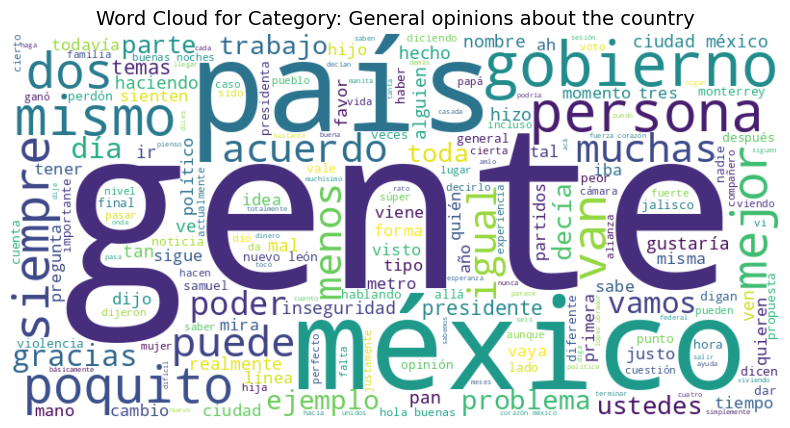

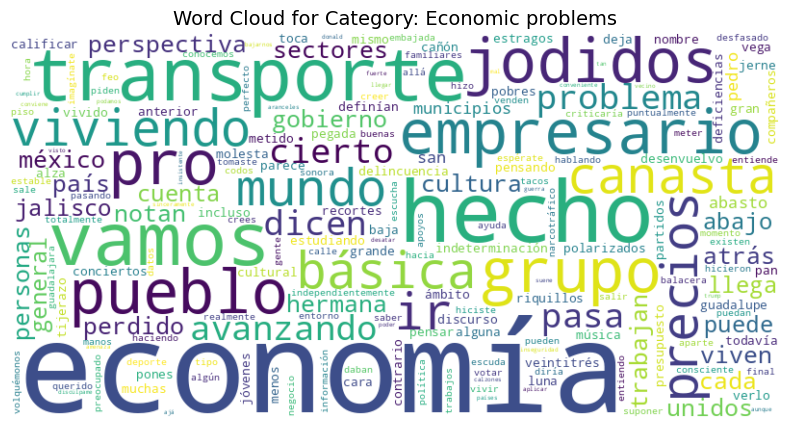

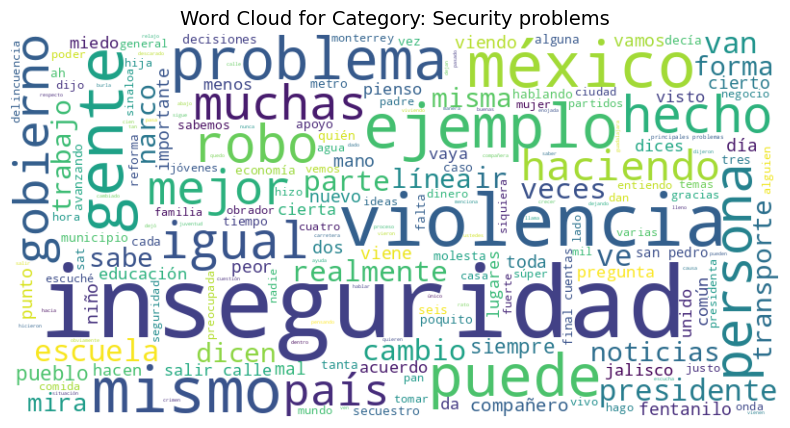

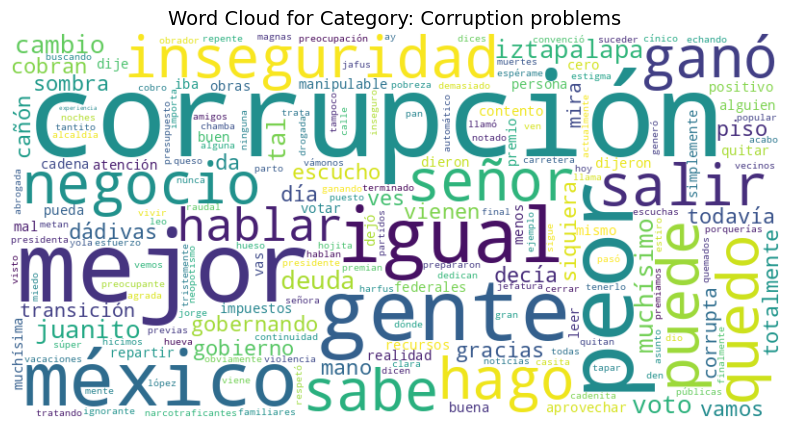

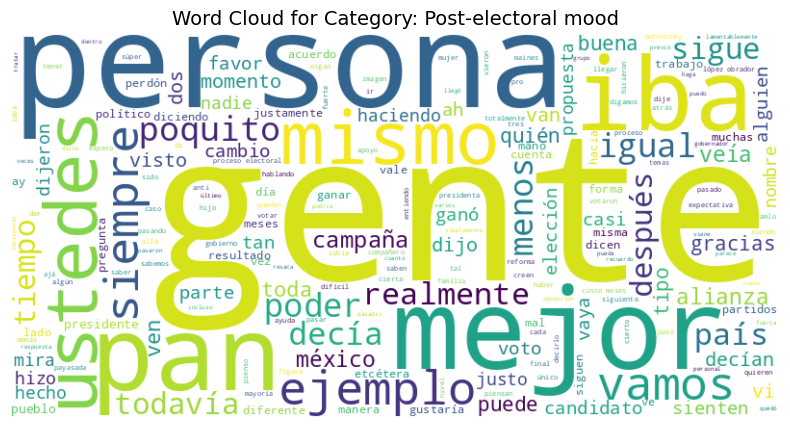

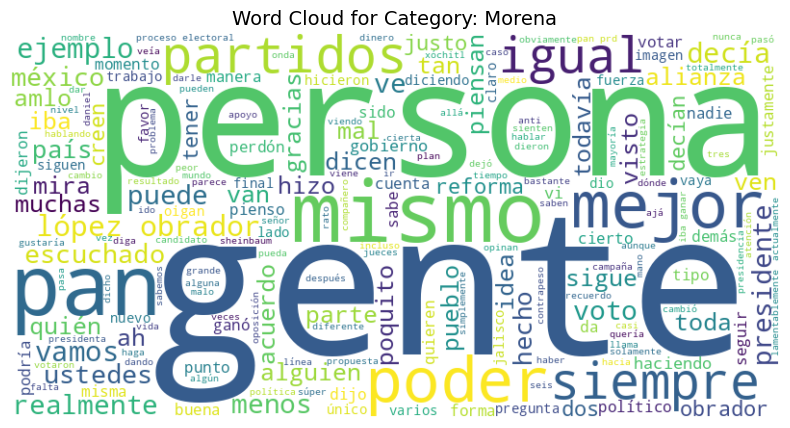

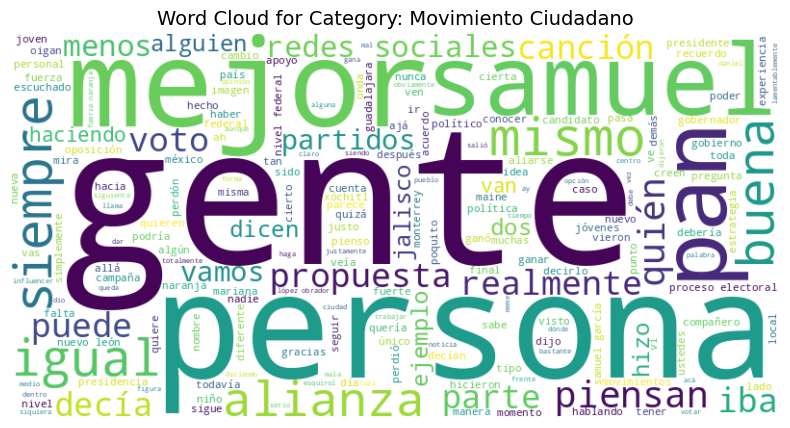

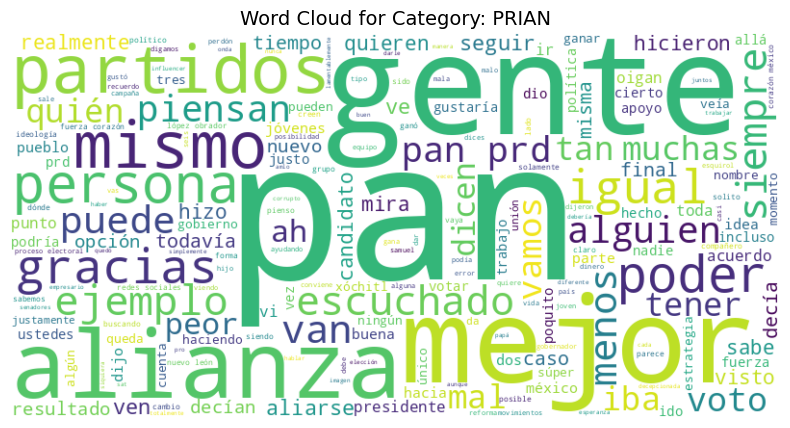

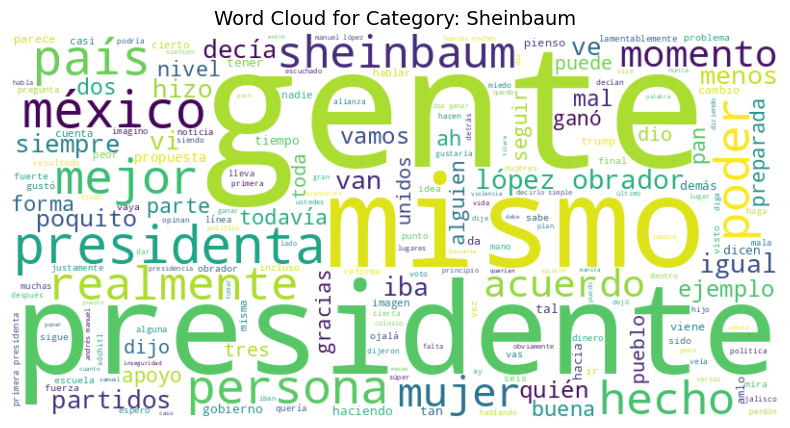

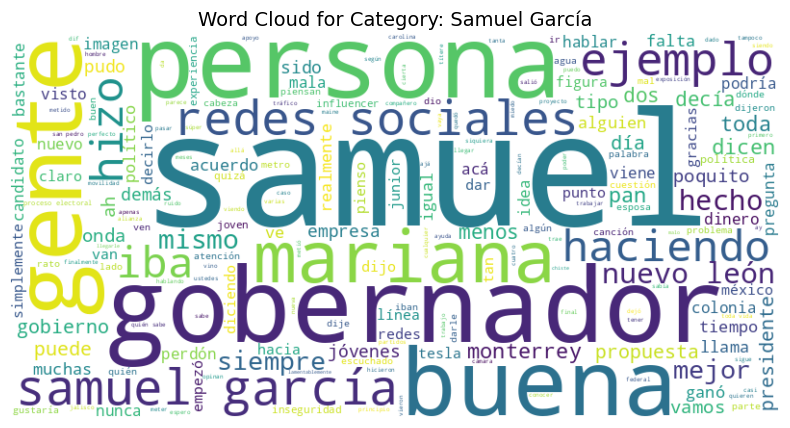

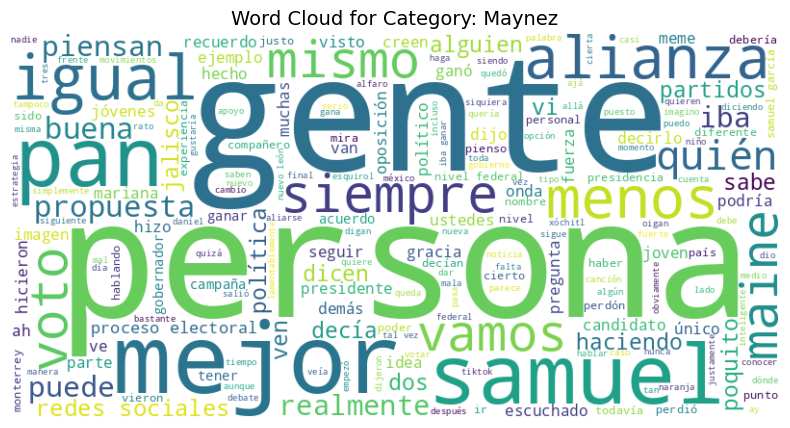

In [ ]:
# Install necessary libraries
!pip install wordcloud matplotlib pandas

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the CSV file
file_path = '/content/Assignment 2/data/participants_beto_sentiment_processed_cleaned.csv'
data = pd.read_csv(file_path)

# Define the target categories
target_categories = [
    "General opinions about the country",
    "Economic problems",
    "Security problems",
    "Corruption problems",
    "Post-electoral mood",
    "Morena",
    "Movimiento Ciudadano",
    "PRIAN",
    "Sheinbaum",
    "Samuel García",
    "Maynez"
]

# Check the columns in the dataset
print(data.columns)

# Generate a word cloud for each target category
if 'Thematic_Categories' in data.columns and 'Cleaned_Participation' in data.columns:
    for category in target_categories:
        # Filter rows where the category appears in 'Thematic_Categories'
        category_data = data[data['Thematic_Categories'].str.contains(category, na=False)]

        # Combine all words in the 'Cleaned_Participation' column for this category
        text = ' '.join(category_data['Cleaned_Participation'].dropna())

        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Category: {category}', fontsize=14)
        plt.axis('off')
        plt.show()
else:
    print("Make sure the columns 'Thematic_Categories' and 'Cleaned_Participation' exist in the CSV file.")


Topic modeling LDA

Lematization

In [ ]:
# Install spaCy and download the Spanish model
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 48.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Import necessary libraries
import spacy
import unicodedata

# Load the Spanish language model
nlp = spacy.load('es_core_news_sm')

# Function to normalize text (remove special characters and preserve accents)
def normalize_text(text):
    if isinstance(text, str):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text

# Function to lemmatize text in Spanish with improved handling
def lemmatize_text(text):
    """
    Lemmatizes the given text using spaCy's Spanish model.
    Removes stopwords and punctuation.
    Handles unusual casing.
    """
    if isinstance(text, str):  # Check if text is a string
        text = text.lower()  # Convert to lowercase to aid lemmatization
        doc = nlp(text)
        lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

        # Manually handle specific cases if needed
        for i, lemma in enumerate(lemmas):
            if lemma == "apagadito":  # Example of a word needing manual correction
                lemmas[i] = "apagar"  # Replace with desired lemma

        return ' '.join(lemmas)
    return ""  # Return an empty string for non-string values

# Normalize and apply lemmatization to the 'Cleaned_Participation' column
if 'Cleaned_Participation' in data.columns:
    # Normalize text
    data['Cleaned_Participation'] = data['Cleaned_Participation'].dropna().apply(normalize_text)
    # Lemmatize text, handling non-string values
    data['Lemmatized_Text'] = data['Cleaned_Participation'].apply(lemmatize_text)
else:
    print("The column 'Cleaned_Participation' does not exist in the dataset.")

# Save the updated DataFrame to a CSV file with proper encoding
output_file_path = '/content/lemmatized_data.csv'
data.to_csv(output_file_path, index=False, encoding='utf-8')

# Verify the new column 'Lemmatized_Text'
print(data['Lemmatized_Text'].head())
print(f"Processed file saved at: {output_file_path}")

0                    acompaname clinica
1          holar noche iir micro apagar
2                                perdon
3            preocup checar iir ignacio
4    iir ignacio brugado burgo servidor
Name: Lemmatized_Text, dtype: object
Processed file saved at: /content/lemmatized_data.csv


In [ ]:
# Path to the lemmatized data file
file_path = '/content/Assignment 2/data/lemmatized_data.csv'

# Load the data into a DataFrame
data = pd.read_csv(file_path)

# Ensure the 'Lemmatized_Text' column exists
if 'Lemmatized_Text' in data.columns:
    print("Column 'Lemmatized_Text' found. Proceeding with LDA.")
else:
    print("Column 'Lemmatized_Text' not found in the dataset. Please check the file.")

# Verify a sample of the lemmatized text
print(data['Lemmatized_Text'].head())


Column 'Lemmatized_Text' found. Proceeding with LDA.
0                    acompaname clinica
1          holar noche iir micro apagar
2                                perdon
3            preocup checar iir ignacio
4    iir ignacio brugado burgo servidor
Name: Lemmatized_Text, dtype: object


In [ ]:
# Ensure all values in 'Lemmatized_Text' are strings
data['Lemmatized_Text'] = data['Lemmatized_Text'].fillna('')  # Replace NaN values with empty strings
data['Lemmatized_Text'] = data['Lemmatized_Text'].astype(str)  # Convert all values to strings

# Tokenize the lemmatized text
texts = [doc.split() for doc in data['Lemmatized_Text']]  # Split each text into tokens

# Import the Dictionary class from gensim.corpora
from gensim.corpora import Dictionary
# Create a dictionary and a corpus
dictionary = Dictionary(texts)  # Map each unique word to an ID
corpus = [dictionary.doc2bow(text) for text in texts]  # Convert texts to a bag-of-words format


# Import the LdaModel class from gensim.models
from gensim.models import LdaModel
# Train the LDA model
num_topics = 5  # Adjust the number of topics as needed
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the generated topics
print("Generated topics:")
for idx, topic in lda_model.print_topics(-1):  # Print all topics
    print(f"Topic {idx}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generated topics:
Topic 0: 0.014*"ir" + 0.011*"llamar" + 0.010*"ver" + 0.008*"cancion" + 0.008*"leon" + 0.007*"mujer" + 0.007*"gano" + 0.006*"persona" + 0.006*"escuchar" + 0.006*"personaje"
Topic 1: 0.026*"pensar" + 0.022*"samuel" + 0.015*"aja" + 0.014*"él" + 0.013*"gente" + 0.013*"pan" + 0.012*"seguir" + 0.012*"alianza" + 0.012*"fuerza" + 0.010*"social"
Topic 2: 0.022*"ver" + 0.016*"perfecto" + 0.014*"electoral" + 0.014*"proceso" + 0.012*"decir" + 0.011*"valer" + 0.010*"poquito" + 0.009*"decia" + 0.009*"él" + 0.009*"hablar"
Topic 3: 0.031*"gracias" + 0.014*"hola" + 0.009*"problema" + 0.008*"mexico" + 0.007*"poquito" + 0.007*"poder" + 0.007*"erick" + 0.007*"metro" + 0.007*"ciudad" + 0.007*"ver"
Topic 4: 0.017*"gente" + 0.014*"él" + 0.013*"reforma" + 0.013*"escuchado" + 0.012*"perdon" + 0.010*"pan" + 0.010*"pueblo" + 0.009*"cambiar" + 0.008*"persona" + 0.008*"pasar"


In [ ]:
# Define the path for the output file
output_file = '/content/lda_topics.csv'

# Extract topics into a structured format
topics = []
for idx, topic in lda_model.print_topics(-1):  # Loop through all topics
    topics.append([idx, topic])  # Append topic index and its content

# Convert topics into a DataFrame
import pandas as pd
topics_df = pd.DataFrame(topics, columns=['Topic_Index', 'Topic_Content'])

# Save the DataFrame to a CSV file
topics_df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Topics saved to {output_file}")


Topics saved to /content/lda_topics.csv


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualisation


In [ ]:
# Install pyLDAvis if not already installed
!pip install pyLDAvis

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Enable notebook visualization (for Colab/Jupyter)
pyLDAvis.enable_notebook()

# Prepare the visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization as an HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')  # Save the visualization locally

print("Visualization saved as 'lda_visualization.html'")  # Notify that the file has been saved


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualization saved as 'lda_visualization.html'


Embedding Analysis


In [ ]:
import torch
import torchvision
from transformers import AutoTokenizer, AutoModel

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
print("BETO loaded successfully!")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BETO loaded successfully!


In [ ]:
import pandas as pd
from tqdm import tqdm

# Load the CSV file
data = pd.read_csv('/content/Assignment 2/data/participants_beto_sentiment_processed_cleaned.csv')

# Function to generate sentence embeddings using BETO
def get_embedding(sentence):
    """
    Generate a sentence embedding using BETO.
    """
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Get the model output
    outputs = model(**inputs)
    # Average the token embeddings to create a single vector for the sentence
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Add a progress bar to monitor the process
tqdm.pandas(desc="Generating embeddings")

# Generate embeddings for all texts in the 'Cleaned_for_Beto' column
data['Embedding'] = data['Cleaned_for_Beto'].progress_apply(lambda x: get_embedding(str(x)))

# Verify that embeddings are generated
print(data['Embedding'].head())

# Save the resulting DataFrame to a CSV file (optional)
data.to_csv('/content/processed_with_embeddings.csv', index=False)
print("Data with embeddings saved to '/content/processed_with_embeddings.csv'")



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Generating embeddings: 100%|██████████| 2542/2542 [08:15<00:00,  5.13it/s]


0    [[-0.27327162, 0.15486811, -0.5813692, 0.11296...
2    [[-0.2976993, -0.21249123, -0.13759603, 0.5198...
4    [[-0.06267174, 0.124563344, -0.090548284, -0.2...
6    [[-0.25683773, -0.07127104, -0.11812132, 0.635...
8    [[-0.28843486, -0.064225174, -0.36234042, 0.28...
Name: Embedding, dtype: object
Data with embeddings saved to '/content/processed_with_embeddings_participants.csv'


In [ ]:
# Save the DataFrame with embeddings to a JSON file
data.to_json('/content/processed_with_embeddings_participants.json', orient='records', lines=True)

print("Data with embeddings saved to '/content/processed_with_embeddings_participants.json'")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data with embeddings saved to '/content/processed_with_embeddings_participants.json'


In [ ]:
# Load the data from the JSON file
data_with_embeddings = pd.read_json('/content/Assignment 2/data/processed_with_embeddings_participants.json', lines=True)

# Verify that the embeddings were loaded correctly
print(data_with_embeddings['Embedding'].head())



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    [[-0.2732716203, 0.154868111, -0.5813692212, 0...
1    [[-0.29769930240000003, -0.21249122920000002, ...
2    [[-0.0626717433, 0.1245633438, -0.0905482844, ...
3    [[-0.2568377256, -0.07127103950000001, -0.1181...
4    [[-0.2884348631, -0.0642251745, -0.36234042050...
Name: Embedding, dtype: object


In [ ]:
# Print one example of an embedding
print(data_with_embeddings['Embedding'].iloc[0])  # This shows the embedding for the first row


[[-0.2732716203, 0.154868111, -0.5813692212, 0.11296592650000001, 0.3270080388, -0.1065851822, -0.6613144875, -0.0779284388, 0.2769878805, -0.2689190507, 0.24371668700000002, 0.2261309624, 0.6544067264, -0.1365801841, 0.1394646466, -0.4066999555, 0.7288946509, -0.7722561359, -0.6020750999000001, 0.1812964082, -0.1094012484, -0.4229587913, -0.0401779264, 0.5597128272, -0.803606987, -0.17727085950000002, -0.38903188710000003, -0.6140431166, 0.20364534850000002, 0.3602150977, -0.136823982, -0.1270768642, -0.5607010722, 0.1266430765, 0.2209772617, -0.8998110890000001, 0.0096491752, -0.6012190580000001, 0.0308788605, 0.030752742700000002, 0.3044605851, 0.0120828627, 0.164568916, 0.12564978000000002, 0.3896830678, 0.6362498999, 0.1616059542, 0.3056722879, -0.3315063417, 0.4350298047, 0.0100022871, -0.2202835381, -0.2552489638, 0.3978025019, 0.3390976787, -0.2664501667, -0.2466301024, 0.0585682094, 0.060609199100000004, 0.3163045645, -0.3708080649, 0.0844284445, 0.0160686113, -0.2519567311, 0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example: Compute similarity between two embeddings
embedding_1 = np.array(data_with_embeddings['Embedding'].iloc[0])  # Convert to NumPy array
embedding_2 = np.array(data_with_embeddings['Embedding'].iloc[1])  # Convert to NumPy array

# Reshape embeddings to 2D arrays
embedding_1 = embedding_1.reshape(1, -1)
embedding_2 = embedding_2.reshape(1, -1)

# Compute cosine similarity
similarity = cosine_similarity(embedding_1, embedding_2)
print(f"Similarity between text 1 and text 2: {similarity[0][0]}")


Similarity between text 1 and text 2: 0.7050504218916622


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create an embedding matrix from the dataset
embedding_matrix = np.vstack(data_with_embeddings['Embedding'].apply(np.array))

# Compute the pairwise cosine similarity matrix
similarity_matrix = cosine_similarity(embedding_matrix)

# Save the similarity matrix to a CSV file
similarity_df = pd.DataFrame(similarity_matrix, columns=data_with_embeddings.index, index=data_with_embeddings.index)
similarity_df.to_csv('/content/similarity_matrix.csv')

print("Similarity matrix saved to '/content/similarity_matrix.csv'")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Similarity matrix saved to '/content/similarity_matrix.csv'


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


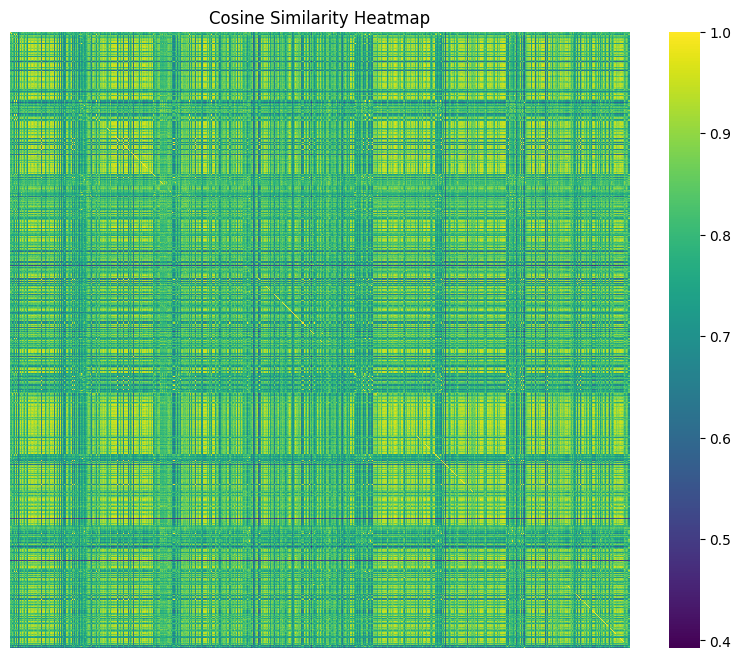

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Heatmap")
plt.show()


Clusterring topics


In [ ]:
import pandas as pd
import numpy as np

# Load the CSV file
original_data = pd.read_csv('/content/processed_with_embeddings_participants.csv')

# Display a sample of the 'Embedding' column
print("Sample of 'Embedding' column before processing:")
print(original_data['Embedding'].head(10))

# Clean the 'Embedding' column and convert it to numeric arrays
def parse_embedding(value):
    try:
        # Remove unwanted characters like \n and extra spaces
        value = value.replace('\n', '').replace('[', '').replace(']', '').strip()
        # Convert the cleaned string into a list of floats
        return np.array([float(x) for x in value.split()])
    except Exception as e:
        print(f"Error processing value: {value}, Error: {e}")
        return None

# Apply the parsing function
print("Parsing the 'Embedding' column...")
original_data['Embedding'] = original_data['Embedding'].apply(parse_embedding)

# Remove rows with invalid embeddings
valid_data = original_data[original_data['Embedding'].notnull()]

# Verify the cleaned data
print(f"Number of valid rows after parsing: {len(valid_data)}")
if len(valid_data) > 0:
    print("Sample of cleaned 'Embedding' column:")
    print(valid_data['Embedding'].head(10))

    # Convert the column to a matrix
    embeddings = np.vstack(valid_data['Embedding'])
    print(f"Embeddings shape: {embeddings.shape}")
else:
    print("No valid embeddings found after parsing.")




Sample of 'Embedding' column before processing:
0    [[-2.73271620e-01  1.54868111e-01 -5.81369221e...
1    [[-2.97699302e-01 -2.12491229e-01 -1.37596026e...
2    [[-6.26717433e-02  1.24563344e-01 -9.05482844e...
3    [[-2.56837726e-01 -7.12710395e-02 -1.18121319e...
4    [[-2.88434863e-01 -6.42251745e-02 -3.62340420e...
5    [[-1.25856131e-01 -5.05731329e-02  9.21970233e...
6    [[ 1.16426423e-02 -1.82272032e-01 -4.88361157e...
7    [[-1.25856131e-01 -5.05731329e-02  9.21970233e...
8    [[-1.25856131e-01 -5.05731329e-02  9.21970233e...
9    [[-5.49619138e-01  3.87116447e-02 -2.11459190e...
Name: Embedding, dtype: object
Parsing the 'Embedding' column...
Number of valid rows after parsing: 2542
Sample of cleaned 'Embedding' column:
0    [-0.27327162, 0.154868111, -0.581369221, 0.112...
1    [-0.297699302, -0.212491229, -0.137596026, 0.5...
2    [-0.0626717433, 0.124563344, -0.0905482844, -0...
3    [-0.256837726, -0.0712710395, -0.118121319, 0....
4    [-0.288434863, -0.0642251745, -0.

In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
num_clusters = 20  # Adjust this number based on your needs

# Apply KMeans clustering
print("Applying KMeans clustering...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
valid_data['Cluster'] = kmeans.fit_predict(embeddings)

# Save the results to a CSV file
output_path = '/content/processed_with_clusters.csv'
valid_data.to_csv(output_path, index=False)

print(f"Clustered data saved to: {output_path}")



Applying KMeans clustering...
Clustered data saved to: /content/processed_with_clusters.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load the dataset
input_path = "/content/processed_with_clusters.csv"
output_path = "/content/reclustered_data.csv"

# Read the CSV file
data = pd.read_csv(input_path)

# Define the clusters we want to keep
relevant_clusters = [0, 1, 18, 19]

# Filter the dataset to include only relevant clusters
filtered_data = data[data['Cluster'].isin(relevant_clusters)].copy()

# Check how the Embedding column is stored
print("First few embeddings before conversion:", filtered_data['Embedding'].head())

# Convert the 'Embedding' column from space-separated string to NumPy array
filtered_data['Embedding'] = filtered_data['Embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ")
)

# Verify the conversion
print("First few embeddings after conversion:", filtered_data['Embedding'].head())

# Convert list of embeddings into a structured DataFrame
embeddings = np.vstack(filtered_data['Embedding'].values)

# Define the number of new clusters (adjust as needed)
num_clusters = 20  # You can change this based on your needs

# Apply KMeans clustering
print("Applying KMeans clustering on the filtered data...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
filtered_data['New_Cluster'] = kmeans.fit_predict(embeddings)

# Save the re-clustered data while keeping all original columns
filtered_data.to_csv(output_path, index=False)

print(f"Re-clustered data saved to: {output_path}")




First few embeddings before conversion: 17    [-2.79672772e-01  1.90288857e-01 -2.46976286e-...
21    [-3.10401797e-01 -2.97420204e-01 -2.37153977e-...
31    [-1.66998729e-01 -2.99011152e-02 -2.47321382e-...
37    [-3.56283635e-01 -1.16677396e-01 -2.56171852e-...
39    [-3.16064268e-01  8.86709616e-02 -4.04716194e-...
Name: Embedding, dtype: object
First few embeddings after conversion: 17    [-0.279672772, 0.190288857, -0.246976286, 0.63...
21    [-0.310401797, -0.297420204, -0.237153977, -0....
31    [-0.166998729, -0.0299011152, -0.247321382, 0....
37    [-0.356283635, -0.116677396, -0.256171852, 0.5...
39    [-0.316064268, 0.0886709616, -0.404716194, 0.4...
Name: Embedding, dtype: object
Applying KMeans clustering on the filtered data...
Re-clustered data saved to: /content/reclustered_data.csv


Reducing dimensionality with t-SNE...


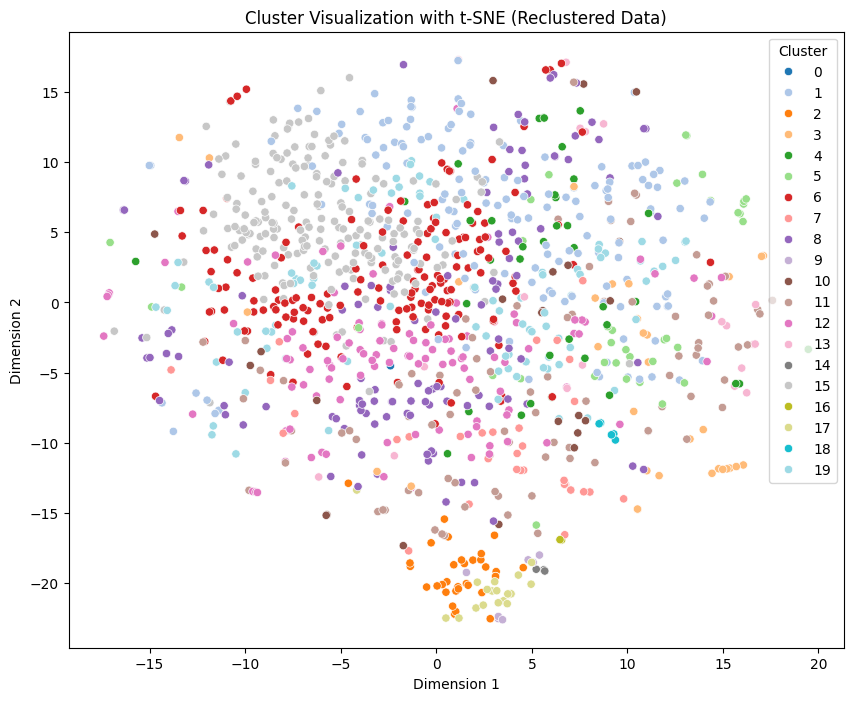

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the re-clustered data
reclustered_data = pd.read_csv("/content/reclustered_data.csv")

# Extract embeddings from the re-clustered data
embeddings = np.vstack(reclustered_data['Embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ")
))

# Reduce embeddings to 2D using t-SNE
print("Reducing dimensionality with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = tsne.fit_transform(embeddings)

# Add reduced dimensions to the re-clustered DataFrame
reclustered_data['Dim1'] = reduced_embeddings[:, 0]
reclustered_data['Dim2'] = reduced_embeddings[:, 1]

# Plot the clusters with a more distinguishable color palette
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1',
    y='Dim2',
    hue='New_Cluster',  # Use the new cluster column
    palette='tab20',
    data=reclustered_data,  # Use the re-clustered data
    legend='full'
)
plt.title("Cluster Visualization with t-SNE (Reclustered Data)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster", loc='upper right')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# ... (previous code) ...

# Load the re-clustered data
reclustered_data = pd.read_csv("/content/reclustered_data.csv")

# Extract embeddings from the re-clustered data
embeddings = np.vstack(reclustered_data['Embedding'].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ")
))

# Reduce embeddings to 3D using t-SNE
print("Reducing dimensionality with t-SNE to 3D...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
reduced_embeddings_3d = tsne_3d.fit_transform(embeddings)

# Add reduced dimensions to the reclustered_data DataFrame
reclustered_data['Dim1'] = reduced_embeddings_3d[:, 0]
reclustered_data['Dim2'] = reduced_embeddings_3d[:, 1]
reclustered_data['Dim3'] = reduced_embeddings_3d[:, 2]

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    reclustered_data,  # Use reclustered_data for plotting
    x='Dim1',
    y='Dim2',
    z='Dim3',
    color='New_Cluster',  # Use the 'New_Cluster' column
    hover_data=['Cleaned_for_Beto'],  # Add hover data
    title="3D Cluster Visualization with t-SNE (Reclustered Data)",
    labels={'New_Cluster': 'Cluster'},  # Update label
    color_discrete_sequence='tab20'
)

# Show the interactive 3D plot
fig.show()

# ... (rest of the code) ...

Reducing dimensionality with t-SNE to 3D...


In [ ]:
# Save the 3D plot as an HTML file
fig.write_html('/content/cluster_visualization_3d.html')

print("3D visualization saved as 'cluster_visualization_3d.html'")


3D visualization saved as 'cluster_visualization_3d.html'


In [ ]:
import shutil
from google.colab import files

# Define the source folder and the output zip file
source_folder = '/content/Assignment 2/data'
output_zip = '/content/Assignment_2_data.zip'

# Compress the folder into a zip file
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', source_folder)

# Download the zip file
files.download(output_zip)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>